In [1]:
# Imports
import torch
from torch.nn.functional import interpolate
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.measure import label
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels


IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = tr.get_input_transform(520, IMG_SIZE)

In [2]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


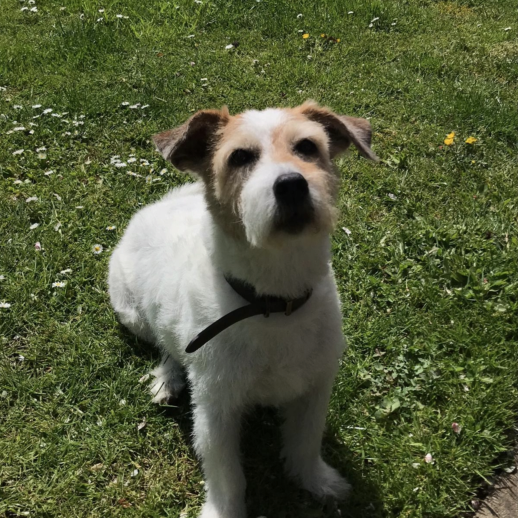

In [3]:
tensor, img = tr.load_image("data/d3.jpg", transform)
tensor.to(torch.float16)
tensor = tensor.cuda()
img

In [5]:
c, h, w = hr_features.shape
reshaped = hr_features.reshape((c, h * w)).T
reshaped = normalise_pca(reshaped)
cluster = KMeans(n_clusters=2)
data = cluster.fit_transform(reshaped)

/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
unary = unary_from_labels(cluster.labels_, 2, 0.7, False)

In [8]:
d = dcrf.DenseCRF2D(w, h, 2)

energy = unary#dist_to_centroid #-1 * np.log(dist_to_centroid)
#u = unary_from_softmax(np.ascontiguousarray(smax2D.T)) #np.ascontiguousarray(energy.T.astype(np.float32))
u = np.ascontiguousarray(energy) #energy.T.astype(np.float32)
d.setUnaryEnergy(u)
compat = [50, 15]
d.addPairwiseGaussian(sxy=(3, 3), compat=10, kernel=dcrf.FULL_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
arr = np.array(img)
print(arr.shape, arr.dtype)
d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=np.array(img), compat=10, kernel=dcrf.FULL_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(10)

(518, 518, 3) uint8


In [8]:
LABEL_CONFIDENCE = 0.7
SXY_G, SXY_B = (3, 3), (80, 80)
SRGB = (13, 13, 13)
COMPAT_G, COMPAT_B = 10, 10
KERNEL = dcrf.FULL_KERNEL

def find_fg_mask(img_arr: np.ndarray, seg: np.ndarray, radius: int=50) -> np.ndarray:
    greyscale_img = Image.fromarray(img_arr).convert('L')
    greyscale_arr = np.array(greyscale_img)
    local_entropy = entropy(greyscale_arr, disk(radius))
    mask_1, mask_2 = seg, ~seg
    avg_entropy_1 = np.sum(mask_1 * local_entropy) / np.sum(mask_1)
    avg_entropy_2 = np.sum(mask_2 * local_entropy) / np.sum(mask_2)
    best_mask_idx = int(np.argmax([avg_entropy_1, avg_entropy_2]))
    print(best_mask_idx)
    if best_mask_idx == 0:
        return mask_1
    else:
        return mask_2
    

def object_segment(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, single_component: bool=True, 
                   verbose: bool=False, net_patch_size: int=14) -> np.ndarray:
    ih, iw, ic = img_arr.shape
    hr_tensor, _ = net.forward(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    reshaped = features.reshape((c, fh * fw)).T

    normed = normalise_pca(reshaped)
    cluster = KMeans(n_clusters=2)
    cluster.fit(normed)
    k_means_labels = cluster.labels_.astype(np.uint8)

    unary = unary_from_labels(k_means_labels, 2, LABEL_CONFIDENCE, zero_unsure=False)
    d = dcrf.DenseCRF2D(iw, ih, 2)
    u = np.ascontiguousarray(unary)
    d.setUnaryEnergy(u)
    d.addPairwiseGaussian(sxy=SXY_G, compat=COMPAT_G, kernel=KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=SXY_B, srgb=SRGB, rgbim=img_arr, compat=COMPAT_B, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(10)
    crf_seg = np.argmax(Q, axis=0)
    crf_seg = crf_seg.reshape((ih, iw, 1))
    fg_seg = find_fg_mask(img_arr, crf_seg)
    fg_seg = fg_seg.astype(np.uint8)
    if single_component:
        labels, n_components = label(fg_seg, background=0, return_num=True)
        fg_seg = labels == np.argmax(np.bincount(labels.flat, weights=fg_seg.flat))
    return fg_seg

In [9]:
fg_seg = object_segment(net, np.array(img), tensor, single_component=False)

(4, 4)
torch.Size([1, 384, 518, 518])
518 518
384 268324


/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0


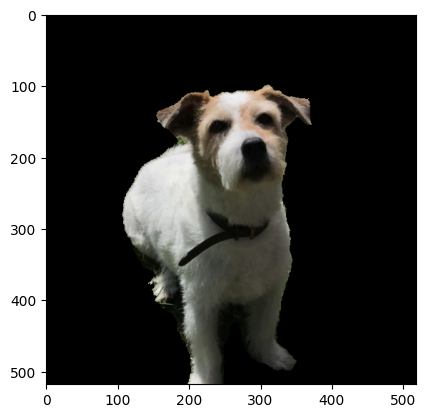

In [10]:
plt.imshow(fg_seg * img)

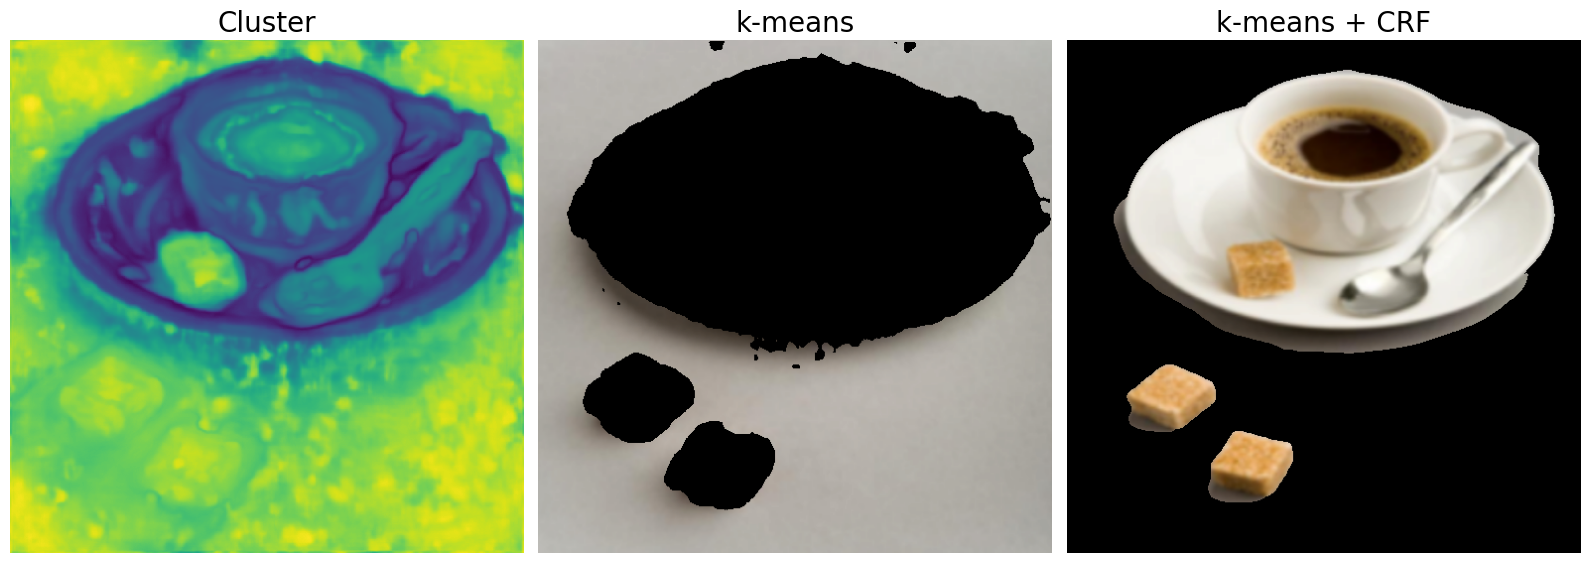

In [ ]:
out = np.argmax(Q, axis=0)
binary = 1 - (out.reshape(h, w, 1))
eroded = binary
for i in range(0):
    eroded = binary_erosion(eroded)

titles = ["Cluster", "k-means", "k-means + CRF"]
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16, 8)
for i, ax in enumerate(axs):
    plot_data: np.ndarray
    if i == 0:
        data2D = data.reshape(h, w, 2)
        plot_data = rescale_pca_img(data2D)[:, :, 0]
    elif i == 1:
        plot_data = (cluster.labels_.reshape(h, w, 1)) * img #binary * img
    else:
        plot_data = eroded * img
    ax.imshow(plot_data)
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=20)
fig.tight_layout()